# SETUP

In [ ]:
#link to the google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #Check the package pyreadr.
 !pip install pyreadr

     |████████████████████████████████| 409 kB 5.5 MB/s 


In [ ]:
import pandas as pd 
import pyreadr as py 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
from google.colab import files
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [ ]:
#TPU

import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TPU address is grpc://10.34.2.34:8470
Running on TPU  grpc://10.34.2.34:8470
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.34.2.34:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.34.2.34:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER

In [ ]:
BASE_SEQ_LEN = 500
NUM_VAR = 52
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

# READ DATA

In [ ]:
a1 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Training.RData")
fault_free_training = a1['fault_free_training']
a1 = None 
a2 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Training.RData")
faulty_training = a2['faulty_training']
a2 = None
a3 = py.read_r("drive/MyDrive/TEP_dataset/TEP_FaultFree_Testing.RData")
fault_free_testing = a3['fault_free_testing']
a3 = None 
a4 = py.read_r("drive/MyDrive/TEP_dataset/TEP_Faulty_Testing.RData")
faulty_testing = a4['faulty_testing']
a4 = None 

In [ ]:
gc.collect()

50

In [ ]:
for col in fault_free_training.columns: 
    fault_free_training.loc[: , col] = fault_free_training.loc[: , col].astype('float32')

for col in faulty_training.columns: 
    faulty_training.loc[: , col] = faulty_training.loc[: , col].astype('float32')

for col in fault_free_testing.columns: 
    fault_free_testing.loc[: , col] = fault_free_testing.loc[: , col].astype('float32')

for col in faulty_testing.columns: 
    faulty_testing.loc[: , col] = faulty_testing.loc[: , col].astype('float32')


In [ ]:
gc.collect()

50

In [ ]:
def df_to_np_array(df = fault_free_training): 
    """ This function will turn the dataframe to numpy array, only use for faulty free dataset
    Parameter: dataframe
    Return: Numpy array
    """
    examples = []
    for i in df.simulationRun.unique():
        examples.append(df[df.simulationRun == i].iloc[:, 3:].values)
    
    return np.stack(examples)


def get_slice_random_segment(length):
    """This function will acquire a length of slice from the dataset.
    Parameter: length, length of the dataset
    return: array
    """
    def slice_random_segment(x):
      """This function will return the specific array
      Parameter: x, dataset
      return: array
      """
      #minval = min numbers of data points, maxval = max numbers of data points
      start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
      x = x[start:start+length]
      print(x)
      #reshape will turn x into the shape of (length, NUM_VAR)
      x = tf.reshape(x, (length, NUM_VAR))
      print(x)
      return x 
    return slice_random_segment

def get_split_xy(y_length):
  """This will get two specific group of data points.
  Parameter: y_length
  return: x, y 
  """
  def split_xy(x):
    """
    Parameter: dataset
    """
    y = x[-y_length:]
    return x[:-y_length], y 
  return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    #Changing the value of buffer_size affects how uniform the shuffling
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 

  
def get_detection_xy(df , simrun, scaler):
    """get the testing dataset
    Parameter: dataset, number of simulation run, the scaler you use in the training process
    return: x:slice of dataset(testing), y:target value
    """
    
    scaled = scaler.transform(df[df.simulationRun == simrun].iloc[:500, 3:])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
    
def get_mse(model, df, scaler, simrun):
    """ Get loss value: the mean squared error value
    Parameter: dataset, simulation run, model
    Return: loss value
    """
    x, y = get_detection_xy(df, simrun, scaler) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()


In [ ]:
def train_model(df, model):
  """This function is to tain the model
  Parameter: df, model
  Return: trained model, and trained scaler
  """
  # train_df = fault_free_training
  train_df = df[:]


  scaler = preprocessing.MinMaxScaler()
  scaler.fit(train_df.iloc[:, 3:].values)

  train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
  train_ds = get_dataset(train_df, shuffle = True, repeat=True)

  model.fit(
      train_ds, 
      epochs = 20,
      steps_per_epoch = 1000,
  )

  return model, scaler

In [ ]:
def get_result( model, baseline, scaler, simrun):
  """This function is to get and plot the result
  Paramter: baseline, simrun, trained model, and trained scaler
  """

  mse_model_1 = get_mse(model, fault_free_testing, scaler, simrun)
  print(len(mse_model_1))
  print(type(mse_model_1))
  print(mse_model_1)
  mse_model_2 = get_mse(model, faulty_testing, scaler, simrun)
  print(len(mse_model_2))
  print(type(mse_model_2))
  print(mse_model_2)
  pd.DataFrame({'normal' : mse_model_1, 'with_fault' : mse_model_2, 'baseline': baseline}).plot(ylim = (0.0, 1.0))

# MODEL

In [ ]:
#CNN
def get_model_CNN_1():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 15, 9,activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [ ]:
#CNN
def get_model_CNN_2():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 4, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [ ]:
#CNN
def get_model_CNN_3():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Conv1D(128, 7, 3, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [ ]:
#CNN
def get_model_CNN_4():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(64, 5, 1,activation= 'relu'),
                              tfkl.Conv1D(64, 5, 1, activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Conv1D(128, 5, 2, activation= 'relu'),
                              tfkl.Conv1D(128, 3, 2, activation= 'relu'),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

# Train the model

In [ ]:
cnn_model_1 = get_model_CNN_1()
cnn_model_1, scaler = train_model(fault_free_training ,cnn_model_1)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 8s 6ms/step - loss: 0.0120
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0107
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0105
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0104
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0104
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0103
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0103
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0103
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0102
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0102
Epoch 11/20
1000/1000 [==============================] - 6s

In [ ]:
cnn_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 128)            99968     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 52)             6708      
Total params: 106,676
Trainable params: 106,676
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_model_2 = get_model_CNN_2()
cnn_model_2, scaler = train_model(fault_free_training ,cnn_model_2)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 8s 6ms/step - loss: 0.0109
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0102
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0099
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0099
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0099
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0099
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0099
Epoch 11/20
1000/1000 [==============================] - 6s

In [ ]:
cnn_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 14, 128)           33408     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            82048     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 128)            65664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 52)             6708      
Total params: 187,828
Trainable params: 187,828
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_model_3 = get_model_CNN_3()
cnn_model_3, scaler = train_model(fault_free_training ,cnn_model_3)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 8s 6ms/step - loss: 0.0111
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0103
Epoch 3/20
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0102
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 11/20
1000/1000 [==============================] - 6s

In [ ]:
cnn_model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 28, 64)            16704     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 64)            20544     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 2, 128)            57472     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 52)             6708      
Total params: 101,428
Trainable params: 101,428
Non-trainable params: 0
________________________________________________

In [ ]:
cnn_model_4 = get_model_CNN_4()
cnn_model_4, scaler = train_model(fault_free_training ,cnn_model_4)

Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 9s 6ms/step - loss: 0.0111
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0104
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0102
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 5/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 6/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 7/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0101
Epoch 8/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 9/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 10/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0100
Epoch 11/20
1000/1000 [==============================] - 6s

In [ ]:
cnn_model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 28, 64)            16704     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 24, 64)            20544     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 4, 128)            41088     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1, 128)            49280     
_________________________________________________________________
dense_3 (Dense)              (None, 1, 52)             6708      
Total params: 134,324
Trainable params: 134,324
Non-trainable params: 0
________________________________________________

# Get the result

15/15 [==============================] - 2s 44ms/step
467
<class 'numpy.ndarray'>
[0.01042227 0.00779087 0.00796565 0.00808081 0.0093192  0.0084127
 0.00938191 0.01138955 0.01460013 0.01444959 0.00532699 0.00873937
 0.01016084 0.00892993 0.00908451 0.00659935 0.011089   0.0107321
 0.00874229 0.01030111 0.01335457 0.01173799 0.01170078 0.00923182
 0.0104855  0.00819037 0.00740877 0.00683537 0.0109342  0.01057185
 0.01343096 0.01323956 0.01420104 0.00928944 0.01311984 0.01787256
 0.01404718 0.01541975 0.01153139 0.01851825 0.00827234 0.00964214
 0.00587014 0.00609957 0.00915287 0.00883861 0.01165891 0.01164452
 0.01343765 0.01168017 0.0102725  0.00755358 0.0109173  0.01185246
 0.01010128 0.01305734 0.00724876 0.00966386 0.00917281 0.0088444
 0.00869804 0.0077747  0.00817478 0.00820777 0.01034725 0.0146154
 0.01159641 0.01045421 0.00928024 0.00817594 0.00930716 0.00889964
 0.00968569 0.00962577 0.00885587 0.00774231 0.01430173 0.01314501
 0.01101782 0.00902346 0.01061101 0.00895906 0.0088

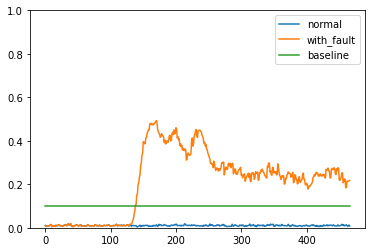

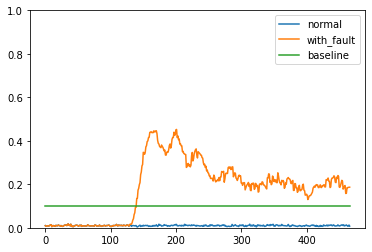

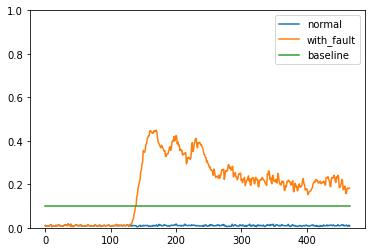

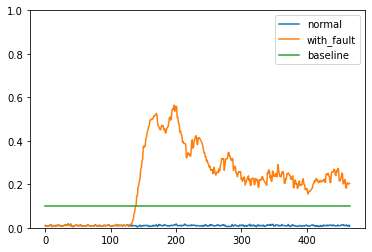

In [ ]:
baseline = 0.1
run = 1
models = [cnn_model_1, cnn_model_2, cnn_model_3, cnn_model_4]


for i in range(len(models)):
  get_result(models[i], 0.1, scaler, run)

In [ ]:
run = 1
mse_f = []
mse_fault_f = []
target = "get_model_CNN_" + str(4) + "()"
for j in range(30):
  cnn_model = eval(target)
  print(cnn_model)
  cnn_model, scaler = train_model(fault_free_training ,cnn_model)
  mse_model_1 = get_mse(cnn_model, fault_free_testing, scaler, run)
  mse_model_2 = get_mse(cnn_model, faulty_testing, scaler, run)
  mse_fault_f.append(mse_model_1)
  mse_f.append(mse_model_2)
  
np.savetxt('myfile.csv', mse_fault_f, delimiter=',', header = "4_fault_free")
np.savetxt('myfile_f.csv', mse_f, delimiter=',', header = "4_fault")

files.download('myfile.csv')
files.download('myfile_f.csv')


Tensor("strided_slice:0", shape=(None, 52), dtype=float32)
Tensor("Reshape:0", shape=(33, 52), dtype=float32)
Epoch 1/20
1000/1000 [==============================] - 12s 9ms/step - loss: 0.0111 - accuracy: 0.0848
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0103 - accuracy: 0.1023
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0102 - accuracy: 0.1045
Epoch 4/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0101 - accuracy: 0.1067
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0101 - accuracy: 0.1069
Epoch 6/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0101 - accuracy: 0.1078
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0101 - accuracy: 0.1088
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0100 - accuracy: 0.1076
Epoch 9/20
1000/1000 [==============================] - 9s 9ms/step - los

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Cross Validation

In [ ]:
#cross validation
for train_split, val_split in KFold().split([i+1 for i in range(500)]):
    train_df = fault_free_training[fault_free_training.simulationRun.isin(train_split)]
    val_df = fault_free_training[fault_free_training.simulationRun.isin(val_split)]

  
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(train_df.iloc[:, 3:].values)

    train_df.iloc[:, 3:] = scaler.transform(train_df.iloc[:, 3:].values)
    val_df.iloc[:, 3:] = scaler.transform(val_df.iloc[:, 3:].values)

    train_ds = get_dataset(train_df, shuffle = True, repeat=True)
    val_ds = get_dataset(val_df)


    model = get_model_1() 


    model.fit(
        train_ds, 
        epochs = 20,
        steps_per_epoch = 1000,
        validation_data= val_ds,
        
    )

    break


Epoch 1/20
1000/1000 [==============================] - 18s 11ms/step - loss: 0.1253 - val_loss: 0.1170
Epoch 2/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0784 - val_loss: 0.0672
Epoch 3/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0535 - val_loss: 0.0463
Epoch 4/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0472 - val_loss: 0.0478
Epoch 5/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0470 - val_loss: 0.0474
Epoch 6/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0468 - val_loss: 0.0471
Epoch 7/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0466 - val_loss: 0.0473
Epoch 8/20
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0460 - val_loss: 0.0422
Epoch 9/20
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0412 - val_loss: 0.0385
Epoch 10/20
1000/1000 [==============================] - 10s 10ms/step -

In [ ]:
#add the ndarray then do the significant test from data point 120

### Test on NGAFID Dataset

In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import gc 
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
import matplotlib as plt
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions


gc.collect() 

pd.options.mode.chained_assignment = None

In [ ]:
BASE_SEQ_LEN = 1000
NUM_VAR = 31
INPUT_SEQ_LEN = 32 
OUTPUT_SEQ_LEN = 1 
BATCH_SIZE = 128

In [ ]:
url = 'https://raw.githubusercontent.com/Rainmaker519/NGAFID_Anomaly_Detection/main/NGAFID_dataset/c172_file_2.csv'
dataset = pd.read_csv(url)

In [ ]:
#cut the dataset to 1000 in the mid point
data = dataset[(int(len(dataset)/2)-499):(int(len(dataset)/2)+501)]

In [ ]:
def df_to_np_array(df): 
    """ This function will turn the dataframe to numpy array
    Parameter: dataframe
    Return: Numpy array
    """
    examples = []
    examples.append(df.iloc[:, :].values)
    
    return np.stack(examples)

def get_slice_random_segment(length):
    """This function will acquire a length of slice from the dataset.
    Parameter: length, length of the dataset
    return: array
    """
    def slice_random_segment(x):
      """This function will return the specific array
      Parameter: x, dataset
      return: array
      """
      #minval = min numbers of data points, maxval = max numbers of data points
      start = tf.random.uniform(shape=[], minval=0, maxval= BASE_SEQ_LEN-length, dtype=tf.int64)
      x = x[start:start+length]
      print(x)
      #reshape will turn x into the shape of (length, NUM_VAR)
      x = tf.reshape(x, (length, NUM_VAR))
      print(x)
      return x 
    return slice_random_segment

def get_split_xy(y_length):
  """This will get two specific group of data points.
  Parameter: y_length
  return: x, y 
  """
  def split_xy(x):
    """
    Parameter: dataset
    """
    y = x[-y_length:]
    return x[:-y_length], y 
  return split_xy

def get_dataset(train_data, shuffle = False, repeat = False): 
    train_data = df_to_np_array(train_data)
    print(train_data)
    ds = tf.data.Dataset.from_tensor_slices(train_data)
    print(ds)
    ds = ds.map(get_slice_random_segment(length = INPUT_SEQ_LEN + OUTPUT_SEQ_LEN))
    ds = ds.map(get_split_xy(y_length=OUTPUT_SEQ_LEN))

    #Changing the value of buffer_size affects how uniform the shuffling
    ds = ds.shuffle(512) if shuffle else ds 
    ds = ds.repeat() if repeat else ds.repeat(2)
    ds = ds.batch(BATCH_SIZE, drop_remainder=True)

    return ds 

  
def get_detection_xy(df , scaler):
    """get the testing dataset
    Parameter: dataset, number of simulation run, the scaler you use in the training process
    return: x:slice of dataset(testing), y:target value
    """
    
    scaled = scaler.transform(df.iloc[:, :])

    x = []
    y = []

    for i in range(BASE_SEQ_LEN - INPUT_SEQ_LEN - OUTPUT_SEQ_LEN):
        x.append(scaled[i:i+ INPUT_SEQ_LEN])
        y.append(scaled[i+INPUT_SEQ_LEN: i + INPUT_SEQ_LEN + OUTPUT_SEQ_LEN])

    x = np.stack(x)
    y = np.stack(y)

    return x,y 
    
    
def get_mse(model, df, scaler):
    """ Get loss value: the mean squared error value
    Parameter: dataset, simulation run, model
    Return: loss value
    """
    x, y = get_detection_xy(df, scaler) 
    y_pred_1 = model.predict(x, verbose = True)
    mse_1 = tfk.losses.MSE(y, y_pred_1).numpy()
    return mse_1.flatten()


In [ ]:
def train_model(df, model):
  """This function is to tain the model
  Parameter: df, model
  Return: trained model, and trained scaler
  """
  train_df = df[:]


  scaler = preprocessing.MinMaxScaler()
  scaler.fit(train_df.iloc[:, :].values)

  train_df.iloc[:, :] = scaler.transform(train_df.iloc[:, :].values)
  train_ds = get_dataset(train_df, shuffle = True, repeat=True)

  model.fit(
      train_ds, 
      epochs = 20,
      steps_per_epoch = 1000,
  )

  return model, scaler

In [ ]:
def get_result( model, baseline, scaler):
  """This function is to get and plot the result
  Paramter: baseline, simrun, trained model, and trained scaler
  """

  mse_model_1 = get_mse(model, data, scaler)
  pd.DataFrame({'normal' : mse_model_1, 'baseline': baseline}).plot(ylim = (0.0, 0.02))

In [ ]:
#LSTM
def get_rnn_model():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.LSTM(64, return_sequences=True), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.LSTM(64, return_sequences=False),
                              tfkl.Dropout(0.5),
                              tfkl.RepeatVector(OUTPUT_SEQ_LEN), 
                              tfkl.LSTM(64, return_sequences=True),
                              tfkl.Dense(NUM_VAR, activation = 'relu')

      ])

      model.compile(optimizer = tfk.optimizers.Adam(learning_rate=1e-4), loss = "mse" )

      return model 

In [ ]:
#CNN
def get_cnn_model():
    with strategy.scope():
      model = tf.keras.Sequential([
                              tf.keras.Input(shape  = (INPUT_SEQ_LEN, NUM_VAR)),
                              tfkl.Conv1D(128, 15, 9,activation= 'relu'),
                              tfkl.MaxPooling1D(),
                              tfkl.Dense(NUM_VAR, activation='sigmoid')

      ])
      model.compile(optimizer= tfk.optimizers.Adam(learning_rate=1e-4), loss='mse')

      return model 

In [ ]:
model_rnn = get_rnn_model()
model_rnn, scaler = train_model(data ,model_rnn)

[[[0.33239963 0.34666667 0.33919741 ... 0.23280313 0.68788216 0.54219745]
  [0.32026144 0.32952381 0.32978319 ... 0.23771652 0.68982768 0.53423567]
  [0.31185808 0.32       0.32065424 ... 0.24591939 0.692607   0.52388535]
  ...
  [0.73762838 0.74380952 0.72613161 ... 0.29018155 0.75541968 0.66321656]
  [0.7264239  0.73809524 0.71500571 ... 0.19999167 0.74819344 0.64171975]
  [0.7124183  0.72761905 0.70074173 ... 0.11967022 0.7409672  0.61783439]]]
<TensorSliceDataset shapes: (1000, 31), types: tf.float64>
Tensor("strided_slice:0", shape=(None, 31), dtype=float64)
Tensor("Reshape:0", shape=(33, 31), dtype=float64)
Epoch 1/20
1000/1000 [==============================] - 41s 33ms/step - loss: 0.0645
Epoch 2/20
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0180
Epoch 3/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0136
Epoch 4/20
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0106
Epoch 5/20
1000/1000 [=================

In [ ]:
model_cnn = get_cnn_model()
model_cnn, scaler = train_model(data ,model_cnn)

[[[0.33239963 0.34666667 0.33919741 ... 0.23280313 0.68788216 0.54219745]
  [0.32026144 0.32952381 0.32978319 ... 0.23771652 0.68982768 0.53423567]
  [0.31185808 0.32       0.32065424 ... 0.24591939 0.692607   0.52388535]
  ...
  [0.73762838 0.74380952 0.72613161 ... 0.29018155 0.75541968 0.66321656]
  [0.7264239  0.73809524 0.71500571 ... 0.19999167 0.74819344 0.64171975]
  [0.7124183  0.72761905 0.70074173 ... 0.11967022 0.7409672  0.61783439]]]
<TensorSliceDataset shapes: (1000, 31), types: tf.float64>
Tensor("strided_slice:0", shape=(None, 31), dtype=float64)
Tensor("Reshape:0", shape=(33, 31), dtype=float64)
Epoch 1/20
1000/1000 [==============================] - 34s 32ms/step - loss: 0.0192
Epoch 2/20
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0094
Epoch 3/20
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0072
Epoch 4/20
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0059
Epoch 5/20
1000/1000 [=================

31/31 [==============================] - 1s 5ms/step


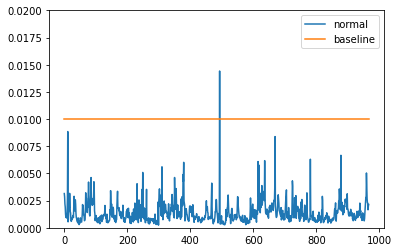

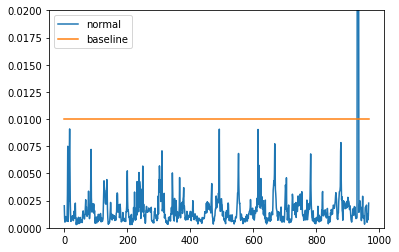

In [ ]:
baseline = 0.01
models = [model_rnn, model_cnn]


for i in range(len(models)):
  get_result(models[i], baseline, scaler)